# Sentence BERT clustering demo

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

## Fetch news dataset

In [7]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
idxs = [ i for i in range(len(newsgroups_train.data)) if len(newsgroups_train.data[i]) > 20 ]
newsgroups_train.data = [ newsgroups_train.data[i] for i in idxs ]
newsgroups_train.target = [ newsgroups_train.target[i] for i in idxs ]

In [8]:
print("Train data size: ", len(newsgroups_train.data))

print("Average train data length: ", np.mean([len(x.split()) for x in newsgroups_train.data]))

print("Train data labels: ", newsgroups_train.target_names)
print("Number of train data labels: ", len(newsgroups_train.target_names))

print(f"Example:\n[{newsgroups_train.target_names[newsgroups_train.target[0]]}] ", newsgroups_train.data[0])

Train data size:  10955
Average train data length:  191.90652670013694
Train data labels:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of train data labels:  20
Example:
[rec.autos]  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car,

In [9]:
with open('app/data/samples.json', 'w') as f:
    json.dump(newsgroups_train.data, f)

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
train_embeddings = model.encode(newsgroups_train.data, show_progress_bar=True)
train_embeddings.shape

Batches: 100%|██████████| 343/343 [02:31<00:00,  2.27it/s]


(10955, 384)

In [11]:
from sklearn.cluster import KMeans
num_clusters = 20 # Could be optimized later using validation indices
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(train_embeddings)

/Users/ser/.envs/aalto-nlp/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
with open('app/data/clusters.json', 'w') as f:
    json.dump(kmeans.labels_.tolist(), f)

## Create the graph using tSNE
We use tSNE simply to reduce the dimensionality of the embeddings to 2D for visualization. This is unnecessary; should remove.

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000, n_iter_without_progress=200, perplexity=35)
tsne_embeddings = tsne.fit_transform(train_embeddings)

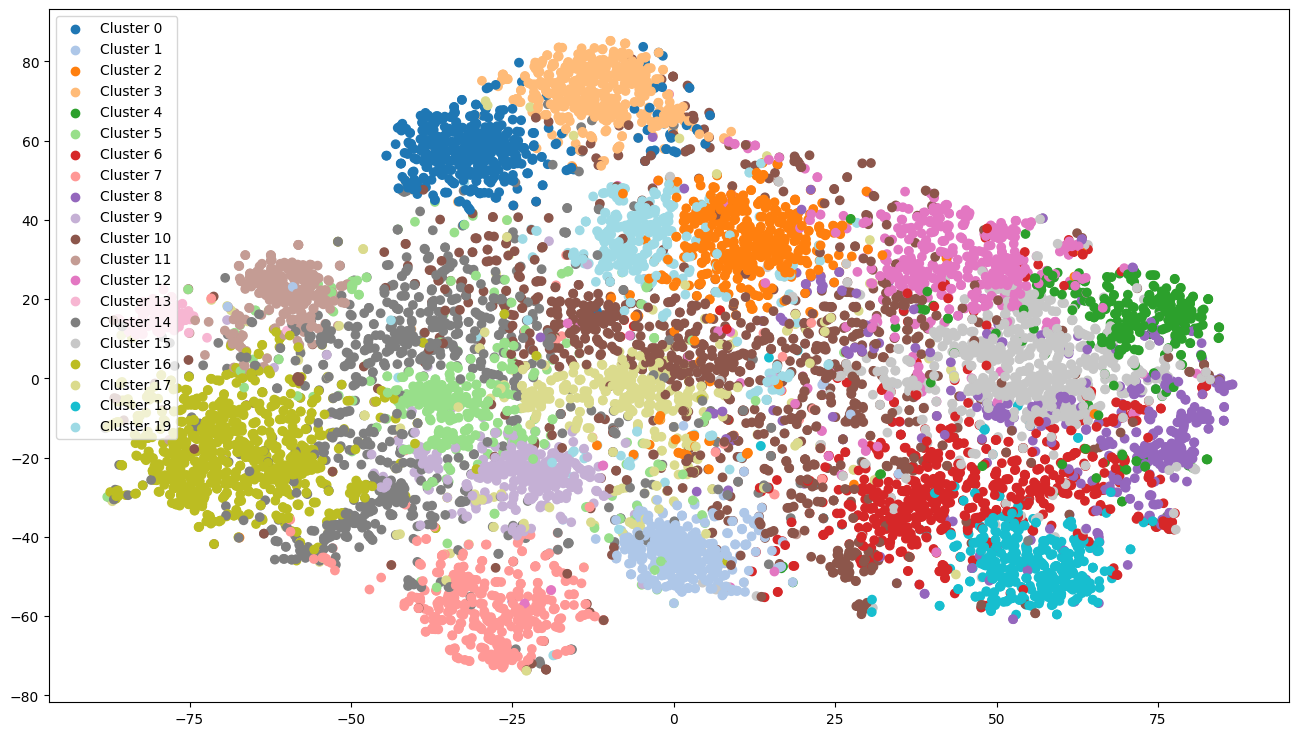

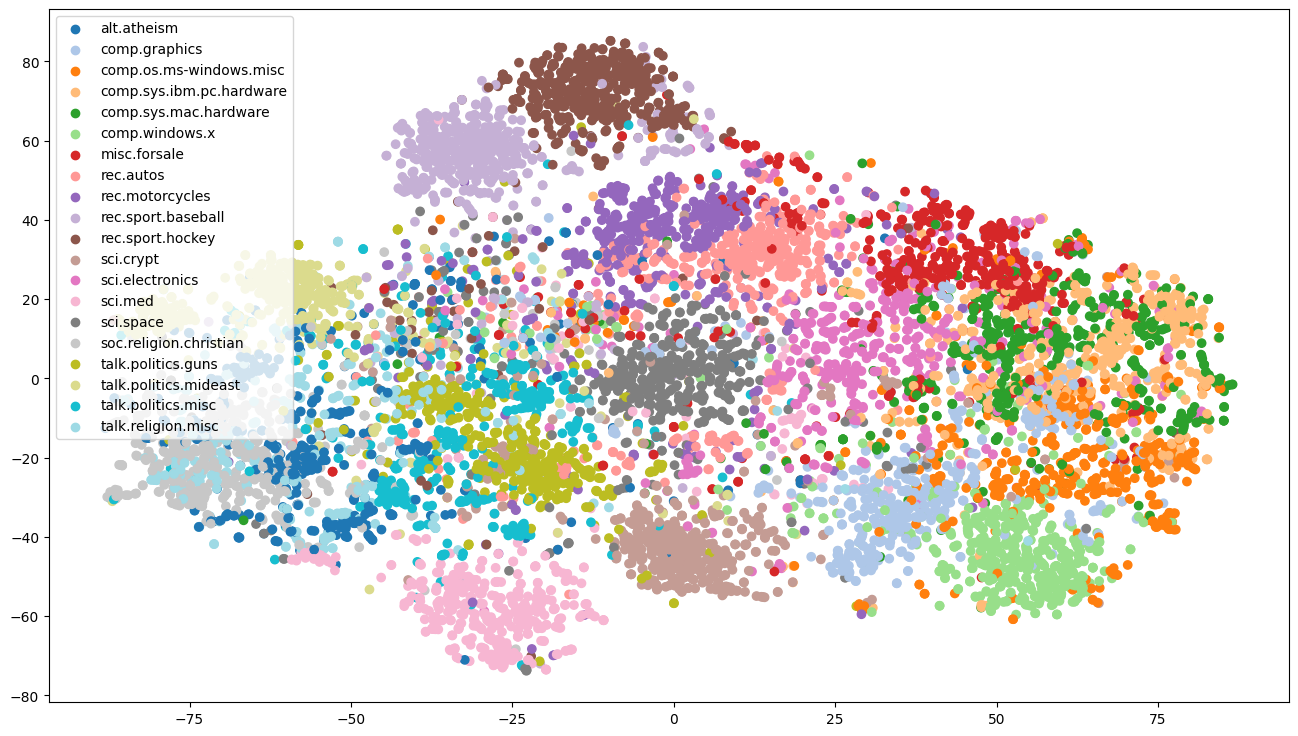

In [14]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}") for i in range(20)])
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)])
plt.show()

## Create the graph using PyVis
Testing the library Pyvis to create an interactive graph in 2D. Good luck loading this lol.

In [15]:
from pyvis.network import Network
net_pred = Network(notebook=True, cdn_resources="in_line")
net_trgt = Network(notebook=True)

for i in range(len(train_embeddings)):
    net_pred.add_node(i, label=newsgroups_train.data[i][:50], color=plt.cm.tab20(kmeans.labels_[i]/20))
    net_trgt.add_node(i, label=newsgroups_train.data[i][:50], color=plt.cm.tab20(newsgroups_train.target[i]/20))

net_pred.show("pred.html")
net_trgt.show("trgt.html")

pred.html
trgt.html


## Cluster labelling
We use LDA.

In [16]:
# Generate topics using LDA for each cluster
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

labels = {i : '' for i in range(num_clusters)}

cluster_keywords = []

for i in range(num_clusters):
    cluster_data = [newsgroups_train.data[j] for j in range(len(newsgroups_train.data)) if kmeans.labels_[j] == i]
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(cluster_data)
    lda = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(X)
    labels[i] = ', '.join([vectorizer.get_feature_names_out()[i] for i in [
        idx for idx in lda.components_[0].argsort() if not vectorizer.get_feature_names_out()[idx].isdigit()
    ][:-1 - 1:-1]])
    print(f"Cluster {i}")
    print("Top 10 words per topic:")
    kwds = []
    for topic_idx, topic in enumerate(lda.components_):
        feature_names = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1] if vectorizer.get_feature_names_out()[i] not in kwds and not vectorizer.get_feature_names_out()[i].isdigit()]
        kwds.extend(feature_names)
        print(f"Topic {topic_idx}: {', '.join(feature_names)}")
    cluster_keywords.append(kwds)
    print()

Cluster 0
Top 10 words per topic:
Topic 0: stance, hit, canseco, com, don, paul, jose, farm, baseball
Topic 1: won, lost
Topic 2: year, game, good, team, think, runs, players, just
Topic 3: cubs, suck, era, sox, games, saves, red, like, stadium, sosa
Topic 4: alomar, baerga, outs, obp, double, extra, stats, plays, defensive, average

Cluster 1
Top 10 words per topic:
Topic 0: privacy, internet, public, information, security, computer, ripem, mail, key, pub
Topic 1: encryption, government, clipper, just, people, use, chip, nsa, keys
Topic 2: email, barbara, does, data, anonymous, conference, crypto
Topic 3: technology, law, administration, new, enforcement, agencies
Topic 4: number, serial, bit, encrypted, block

Cluster 2
Top 10 words per topic:
Topic 0: __, autos, rec, discussion, newsgroup, car, saab, new, article, ___
Topic 1: like, just, good, cars, engine, don, better, price
Topic 2: bike, bikes, looking, used, honda, thanks, motorcycle, horses, years
Topic 3: mm, ww, bmw, send, r

In [24]:
with open('app/data/labels.json', 'w') as f:
    node_labels = [ labels[cluster] for cluster in kmeans.labels_.tolist() ]
    json.dump(node_labels, f)

## Obtaining a 1-word summary of the keywords
It does not work well for now, we could perhaps improve it by training a model on (doc, topic) pairs comming from the intial dataset.

In [17]:
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

query = f"A single word to define the topic given by the keywords [{', '.join(cluster_keywords[2])}] is: "
inputs = tokenizer(query, return_tensors='pt').input_ids
outputs = model.generate(inputs, max_new_tokens=10, do_sample=False)
label = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(label)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A single word to define the topic given by the keywords [__, autos, rec, discussion, newsgroup, car, saab, new, article, ___, like, just, good, cars, engine, don, better, price, bike, bikes, looking, used, honda, thanks, motorcycle, horses, years, mm, ww, bmw, send, requests, request, com, rally, rear, know, does, air, tank, exhaust] is: ____, ____, ____, ____


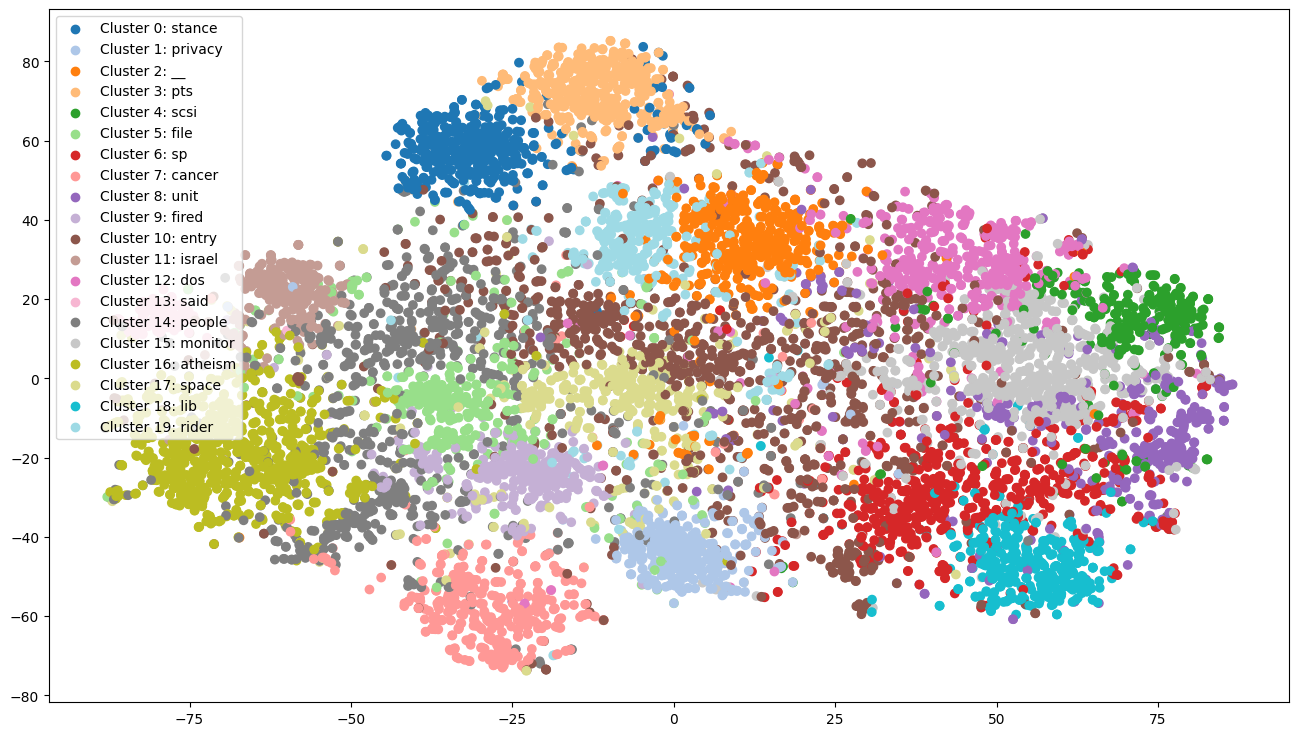

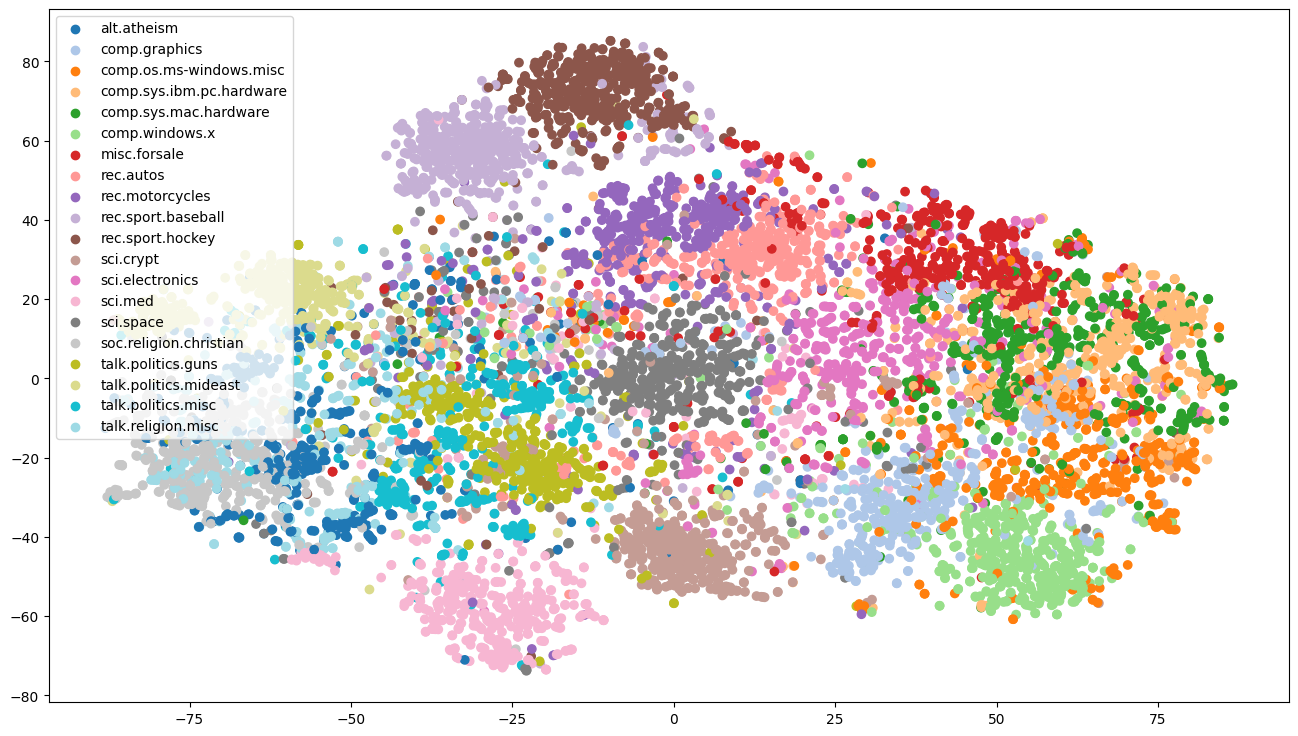

In [18]:
plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=kmeans.labels_, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=f"Cluster {i}: {labels[i]}") for i in range(20)])
plt.show()

plt.figure(figsize=(16, 9))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=newsgroups_train.target, cmap='tab20')
plt.legend(handles=[plt.scatter([],[],color=plt.cm.tab20(i/20), label=newsgroups_train.target_names[i]) for i in range(20)])
plt.show()